# Step 1: Setting Up the Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
from skimage.io import imread as scipy_imread
from skimage.transform import resize as scipy_imresize
import h5py
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.layers import Convolution2D, Input
from keras import backend as K
import warnings

# Wrapper functions to suppress warnings
def imread(*args, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return scipy_imread(*args, **kwargs)

def imresize(*args, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return scipy_imresize(*args, **kwargs)

# Set random seed for reproducibility
np.random.seed(1)
print("Random integers:", np.random.randint(0, 100, 10))

Using TensorFlow backend.


Random integers: [37 12 72  9 75  5 79 64 16  1]


# Step 2: Loading the Pretrained ResNet50 Model

In [2]:
# Load ResNet50 without the top layer
base_model = ResNet50(include_top=False, weights='imagenet')
print("Base model output shape:", base_model.output_shape)
print(base_model.summary())

# Inspect the last layer
res5c = base_model.layers[-1]
print("Type of last layer:", type(res5c))
print("Output shape of last layer:", res5c.output_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



c:\users\kerem\github\python-keras-deep-learning\myenv\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Base model output shape: (None, None, None, 2048)
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_________________________________________

# Step 3: Transforming into a Fully Convolutional Network

In [3]:
from keras.layers import Layer

# Custom SoftmaxMap layer to apply softmax spatially
class SoftmaxMap(Layer):
    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super(SoftmaxMap, self).__init__(**kwargs)

    def build(self, input_shape):
        pass  # No trainable parameters

    def call(self, x, mask=None):
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    def compute_output_shape(self, input_shape):
        return input_shape

# Build the fully convolutional model
input = base_model.input
x = base_model.output
x = Convolution2D(1000, (1, 1), name='conv_1000')(x)  # 1x1 conv for 1000 classes
output = SoftmaxMap(axis=-1)(x)

fully_conv_ResNet = Model(inputs=input, outputs=output)
print("Fully convolutional model output shape:", fully_conv_ResNet.output_shape)

Fully convolutional model output shape: (None, None, None, 1000)


# Step 4: Loading Pretrained Dense Weights

In [4]:
# Load weights from the dense layer
with h5py.File('Files/weights_dense.h5', 'r') as h5f:
    w = h5f['w'][:]
    b = h5f['b'][:]

# Reshape weights for convolutional layer
w_reshaped = w.reshape((1, 1, 2048, 1000))  # (kernel_height, kernel_width, input_channels, output_channels)

# Set weights for the convolutional layer
conv_layer = fully_conv_ResNet.get_layer('conv_1000')
conv_layer.set_weights([w_reshaped, b])

# Step 5: Performing a Forward Pass

Image shape before resizing: (1600, 2560, 3)
Image batch shape before forward pass: (1, 224, 224, 3)

Prediction map shape: (1, 7, 7, 1000)


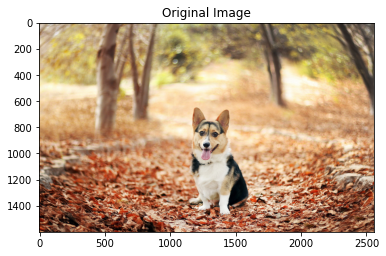

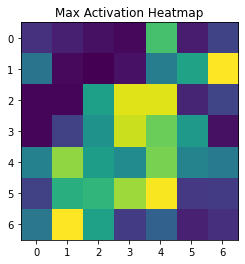

In [5]:
def forward_pass_resize(img_path, img_size):
    img_raw = imread(img_path)
    print("Image shape before resizing:", img_raw.shape)
    img = imresize(img_raw, img_size, mode='reflect', preserve_range=True).astype("float32")
    img = preprocess_input(img[np.newaxis])
    print("Image batch shape before forward pass:", img.shape)
    z = fully_conv_ResNet.predict(img)
    return z, img_raw

# Test with dog.jpg
output, input_img = forward_pass_resize("Files/dog.jpg", (224, 224))
print("Prediction map shape:", output.shape)

# Visualize
plt.imshow(input_img)
plt.title("Original Image")
plt.show()
plt.imshow(output[0].max(axis=-1))
plt.title("Max Activation Heatmap")
plt.show()

# Step 6: Generating Dog-Specific Heatmaps

Image shape before resizing: (1600, 2560, 3)
Image batch shape before forward pass: (1, 400, 640, 3)
Heatmap shape: (118, 13)


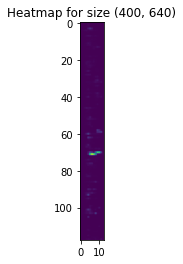

Image shape before resizing: (1600, 2560, 3)
Image batch shape before forward pass: (1, 800, 1280, 3)
Heatmap shape: (118, 25)


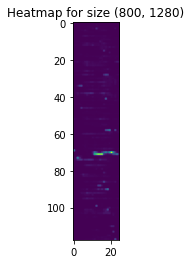

Image shape before resizing: (1600, 2560, 3)
Image batch shape before forward pass: (1, 1600, 2560, 3)
Heatmap shape: (118, 50)


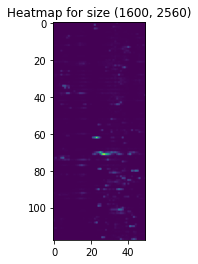

In [6]:
from Files.imagenet_tool import synset_to_dfs_ids, id_to_words

# Dog synset
synset = "n02084071"  # Dogs

def build_heatmap(z, synset):
    class_ids = synset_to_dfs_ids(synset)
    class_ids = [id_ for id_ in class_ids if id_ is not None and id_ < 1000]  # Filter valid IDs
    x = z[0, :, :, class_ids].sum(axis=-1)
    print("Heatmap shape:", x.shape)
    return x

# Generate heatmaps at different scales
sizes = [(400, 640), (800, 1280), (1600, 2560)]
heatmaps = []
for size in sizes:
    output, _ = forward_pass_resize("Files/dog.jpg", size)
    heatmap = build_heatmap(output, synset)
    heatmaps.append(heatmap)
    plt.imshow(heatmap, cmap="viridis")
    plt.title(f"Heatmap for size {size}")
    plt.show()

# Step 7: Combining Heatmaps

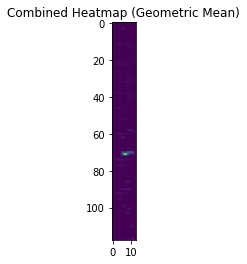

In [7]:
from skimage.transform import resize

# Resize heatmaps to the same size and compute geometric mean
target_size = heatmaps[0].shape
resized_heatmaps = [resize(h, target_size, mode='reflect') for h in heatmaps]

# Geometric mean
heatmap_geom_avg = np.exp(np.mean([np.log(h + 1e-10) for h in resized_heatmaps], axis=0))

# Visualize
plt.imshow(heatmap_geom_avg, cmap="viridis")
plt.title("Combined Heatmap (Geometric Mean)")
plt.show()